<a href="https://colab.research.google.com/github/prozorovpro/kaggle_project/blob/main/Bank_customer_churn_Prediction/kaggle_bank_customer_churn_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting Bank Customer Turnover
Using the Bank Turnover Dataset, we aim to predict whether bank customers will churn in the next cycle. The dataset offers insights into customer behavior within the banking sector.

Dataset Source: [Bank Customer Churn Modeling](https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling)

In [1]:
!pip install imbalanced-learn -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import ADASYN

In [3]:
RS = 420586

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/Churn_Modelling.csv')

Посмотрим на данные

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8381,8382,15764314,Reilly,550,Germany,Male,36,2,113877.23,2,1,0,174921.91,0
949,950,15620981,Wickham,684,France,Female,48,3,73309.38,1,0,0,21228.34,1
8565,8566,15749068,Nickson,632,France,Female,40,9,139625.34,1,1,0,93702.96,1
2102,2103,15802351,Beers,755,Germany,Female,33,6,90560.30,2,1,1,42607.69,0
3129,3130,15694453,Walker,631,Germany,Male,37,9,131519.49,2,1,1,51752.18,0
9612,9613,15794297,McKay,776,France,Male,36,1,0.00,2,1,0,53477.76,0
8290,8291,15731267,Rizzo,797,France,Male,37,4,75263.70,1,1,0,85801.77,0
2257,2258,15698349,Davy,686,Spain,Female,35,4,0.00,2,1,1,159676.55,0
9020,9021,15807194,Iweobiegbulam,718,Spain,Male,34,5,113922.44,2,1,0,30772.22,0
8923,8924,15570002,Burlingame,625,Germany,Female,55,8,118772.71,4,0,0,135853.62,1


In [8]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


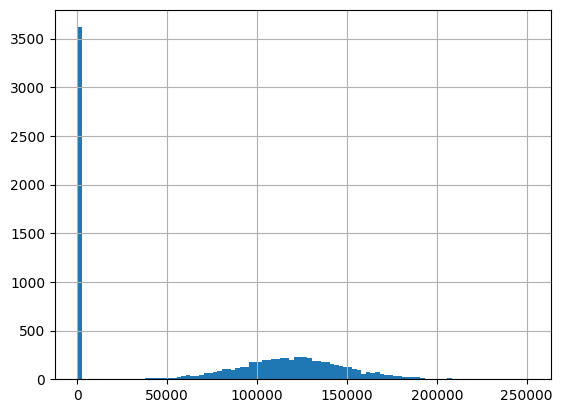

In [11]:
df['Balance'].hist(bins=100);

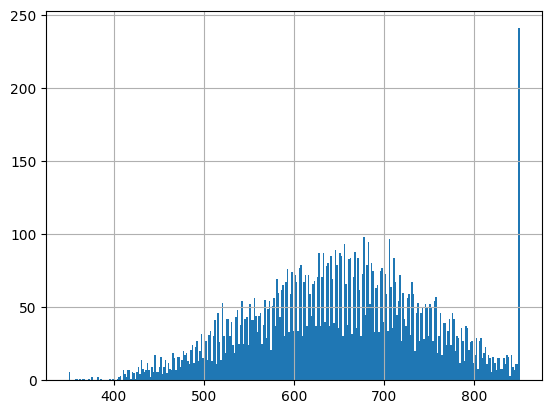

In [12]:
df['CreditScore'].hist(bins=300);

### Preprocessing

In [13]:
df['Gender'].replace({'Female':1,'Male':0},inplace=True)
df['Geography'].replace({'France':1,'Spain':0, 'Germany':3},inplace=True)

In [14]:
# Data Split: Features (X) and Target Variable (y) Separation
X = df.drop('Exited', axis=1)
y = df['Exited']

adasyn = ADASYN(random_state=RS,)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=RS)

# Categorical Feature Identification
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember','NumOfProducts']
numeric_features = [col for col in X.columns if col not in categorical_features]

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
        ('num', StandardScaler(), numeric_features),
    ],
)

### CatBoost

In [16]:
%%time

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        verbose=False,
        random_seed=RS,
        #feature_weights = [2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0],
        #border_count=128,
        #auto_class_weights='SqrtBalanced',
    ))
])

param_dist = {
    'model__iterations' : range(500, 1501, 100),
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [6, 7, 8, 9, 10],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RS)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=0,
    random_state=RS,
)

cat = random_search.fit(X_train, y_train)

print('F1 Score on Train Set:', cat.best_score_)

F1 Score on Train Set: 0.8656068319361679
CPU times: user 30.9 s, sys: 3.39 s, total: 34.2 s
Wall time: 20min 15s


### LGBM

In [17]:
%%time

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        random_state=RS,
        verbose=-1,
        boosting_type='gbdt',
    ))
])

param_dist = {
    'model__min_child_samples' : [10, 20, 30, 40],
    'model__n_estimators': range(500, 1501, 100),
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 63, 127, 255],
    'model__max_depth': [6, 7, 8, 9, 10],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RS)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    cv=cv,
    random_state=RS
)

lgbm = random_search.fit(X_train, y_train)

print('F1 Score on Train Set:', lgbm.best_score_)

F1 Score on Train Set: 0.8676471996252992
CPU times: user 4.37 s, sys: 400 ms, total: 4.77 s
Wall time: 2min 39s


### XGboost

In [18]:
%%time

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        verbosity=1,
        random_state=RS,
    ))
])

param_dist = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': range(500, 1501, 100),
    'model__max_depth': [6, 7, 8, 9, 10],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RS)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=0,
    random_state=RS,
)

xgb = random_search.fit(X_train, y_train)

print('F1 Score on Train Set:', xgb.best_score_)

F1 Score on Train Set: 0.8637411355673116
CPU times: user 43.4 s, sys: 1.48 s, total: 44.9 s
Wall time: 16min 46s


## Model Evaluation


In [20]:
best_model = lgbm

In [21]:
predictions_test = best_model.predict(X_test)
result = f1_score(y_test, predictions_test)
print('F1',result)

F1 0.8679999999999999


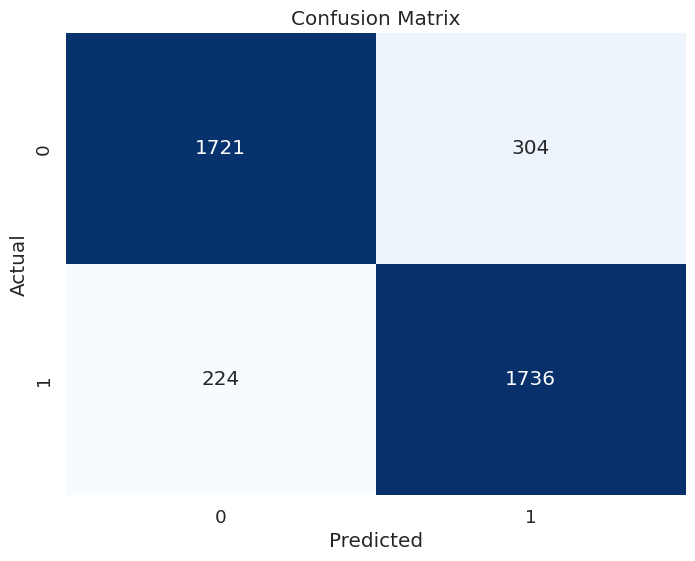

In [22]:
conf_matrix = confusion_matrix(y_test, predictions_test)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

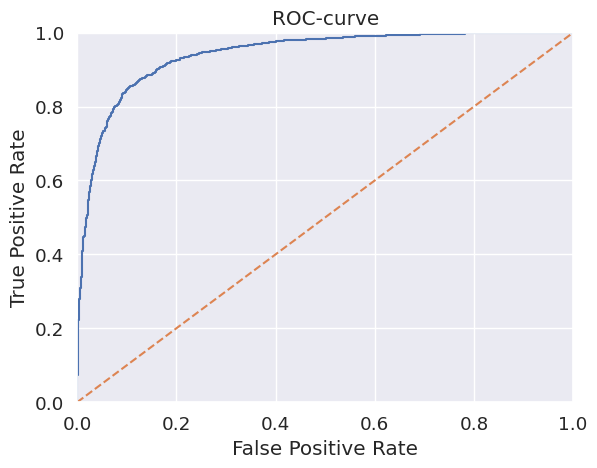

roc_auc_score:  0.9411725875535398


In [23]:
probabilities_valid = best_model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('roc_auc_score: ',roc_auc_score(y_test, probabilities_one_valid))

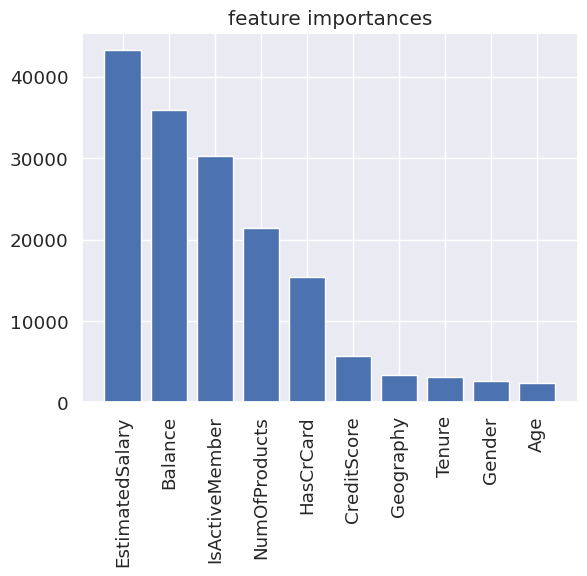

In [24]:
feature_importances = pd.DataFrame(index = X_train.columns,
                                   data = best_model.best_estimator_['model'].feature_importances_)
top_feature = feature_importances.sort_values(by = [0], ascending=False).head(20)

plt.bar(top_feature.index , top_feature[0]);
plt.title('feature importances')
plt.xticks(rotation=90)

plt.show()

## Conclusion

The **LightGBM ** emerged as the top-performing model, boasting an impressive F1 score of **0.87** on the test dataset. Its **ROC AUC score of 0.94** underscores its ability to effectively distinguish between classes. It's worth noting that the **CatBoostClassifier** and **XGboost** model also demonstrated a similar level of performance during cross-validation.

Thank you for taking the time to review my work.